<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/ARMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An ARMA model, or Autoregressive Moving Average model, is used to describe weakly stationary stochastic time series in terms of two polynomials. The first of these polynomials is for autoregression, the second for the moving average.

Often this model is referred to as the ARMA(p,q) model; where:

* p is the order of the autoregressive polynomial,
* q is the order of the moving average polynomial.

The equation is given by:

\begin{align}
        \mathbf{x_t} = \mathbf{w_t} + \sum_{i=1}^q \alpha_i x_{t-i} + \sum_{i=1}^p \beta_i w_{t-i}
        &
    \end{align}


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from time import time
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Vizualise the Stock Price Over Time

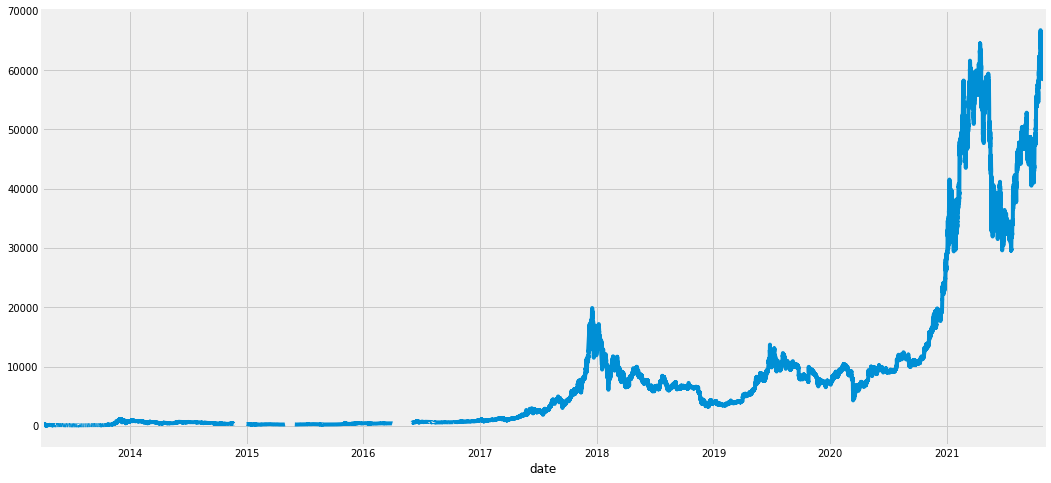

In [9]:
#read data
df = pd.read_csv('/content/drive/MyDrive/Yoctobe Fintech/Datasets/btcusd30mn.csv', parse_dates=True)
df.head()
# #setting index as date because some statsmodels might not work
df.rename(columns={'datetime': 'date'}, inplace=True)
df.index = df['date']
df.index = pd.to_datetime(df.index)
#plot
df['close'].plot(figsize=(16,8))

In [10]:
ddf.head()

,open,close,high,low,volume
date,,,,,
2013-04-01,98.341387,98.342014,98.393186,98.299960,20.210070
2013-04-02,107.406548,107.421507,107.478871,107.330465,23.525159
2013-04-03,129.695725,129.775855,130.021478,129.470340,19.684616
2013-04-04,132.153457,132.152799,132.305456,132.024805,12.921549
2013-04-05,138.179964,138.235598,138.302046,138.124062,12.614668


# Identify the correct ARMA Model Order
## Visualising ACF Plot and PACF Plots
The bars inside the blue shaded region then they are not statistically significant.
* PACF is the autocorrelation that is just associated with just k lags
* PACF cuts off after lag k = q; ACF cuts off after lag k = p; 

"Cuts off" means that it becomes zero abruptly, and "tails off" means that it decays to zero asymptotically (usually exponentially).

In your picture, the PACF "cuts off" after the 2nd lag, while the ACF "tails off" to zero. You probably have something like an AR(2).



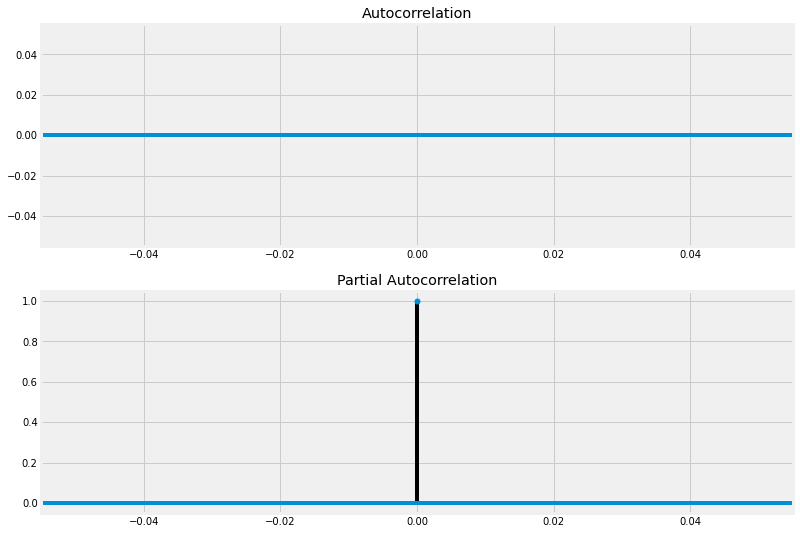

In [12]:
# Download the datafile from yfinance
ddf = df.resample("D").mean()
# using a range of dates
mask = (ddf.index > '2013-03-01') & (ddf.index <= '2021-03-01')
ddf = ddf.loc[mask]

fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(211)
fig = plot_acf(ddf['close'].values.squeeze(), lags=40, fft=True, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(ddf['close'], lags=40 ,ax=ax2)